In [1]:
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Dataset import Dataset
from Setting import Setting

torch.cuda.is_available()

False

# General settings

In [2]:
# Set the random seed for reproducibility.
random_seed = 1
#tf.random.set_random_seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

args = Setting()
device = args.device
dataset = Dataset(args.dataset_path, args.batch_size, args.fast_testing)

# Preprocess dataframe

In [3]:
dataframe = dataset.data_full.drop_duplicates(subset=['UserID', 'MovieID', 'Timestamp'])
dataframe

,UserID,MovieID,CategoryID,Rating,Timestamp
474,101,177,4,4,874724710
178269,101,289,7,4,874724727
90841,101,153,0,4,874724754
45079,101,361,10,4,874724781
175466,101,321,0,4,874724843
...,...,...,...,...,...
98754,724,890,0,4,893286638
157460,724,652,0,4,893286638
98345,724,98,0,3,893286638
168106,724,130,7,4,893286638


In [4]:
# Converts timestamp in a DateTime object.
dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], unit='s')
dataframe = dataframe.sort_values(by='Timestamp')
dataframe['Month'] = dataframe['Timestamp'].dt.to_period('M')
dataframe

,UserID,MovieID,CategoryID,Rating,Timestamp,Month
474,101,177,4,4,1997-09-20 03:05:10,1997-09
178269,101,289,7,4,1997-09-20 03:05:27,1997-09
90841,101,153,0,4,1997-09-20 03:05:54,1997-09
45079,101,361,10,4,1997-09-20 03:06:21,1997-09
175466,101,321,0,4,1997-09-20 03:07:23,1997-09
...,...,...,...,...,...,...
98754,724,890,0,4,1998-04-22 23:10:38,1998-04
157460,724,652,0,4,1998-04-22 23:10:38,1998-04
98345,724,98,0,3,1998-04-22 23:10:38,1998-04
168106,724,130,7,4,1998-04-22 23:10:38,1998-04


In [5]:
distribution_per_month = dataframe['Month'].value_counts().sort_index()
distribution_per_month

1997-09     6704
1997-10    10304
1997-11    23980
1997-12    11911
1998-01    14095
1998-02    10991
1998-03    12656
1998-04     9359
Freq: M, Name: Month, dtype: int64

# Preference change from first month

In [6]:
def get_user_distribution(user_dataframe, user_items):
    
    user_movies_data = dataset.movies_data[dataset.movies_data['MovieID'].isin(user_items)]
    
    # We merge the relevant items with their categories. Then we drop useless attributes.
    merged_df = pd.merge(user_dataframe, user_movies_data, on='MovieID', how='inner')
    merged_df  = merged_df.drop('Timestamp', axis=1) 
    merged_df  = merged_df.drop('UserID', axis=1)
    merged_df  = merged_df.drop('CategoryID', axis=1)
    
    # We assign the rating of the item to each of its categories. 
    for i in range(dataset.n_categories):
        category_col = f'Category_{i}'
        rating_col = 'Rating'
        merged_df[category_col] *= merged_df[rating_col]
    merged_df = merged_df.drop('Rating', axis=1)
    merged_df = merged_df.drop_duplicates()
    
    # We compute the mean value for each category. This is the user profile.
    categories = [f'Category_{i}' for i in range(dataset.n_categories)]
    category_values = []
    for category in categories:
        # We compute the mean only for the values that are not 0,
        # since we consider 0 as an absence of value.
        values = merged_df[category].values
        values = values[values != 0]
        if len(values) > 0:
            values = np.mean(values)
            values = round(values)
        else:
            values = 0
        category_values.append(values)
        
    if all(value == 0 for value in category_values):
        active_user = False
    else:
        active_user = True

    user_distribution = torch.nn.functional.softmax(torch.FloatTensor(category_values), dim=0)
    
    return user_distribution, active_user

In [7]:
first_month = "1997-09"
second_month = "1997-10"
third_month = "1997-11"
fourth_month = "1997-12"
fifth_month = "1998-01"
sixth_month = "1998-02"
seventh_month = "1998-03"
eighth_month = "1998-04"
months_list = [first_month, second_month, third_month, fourth_month, fifth_month,
               sixth_month, seventh_month, eighth_month]
dataframe['Month'] = dataframe['Month'].astype(str)

In [8]:
months_list_time_slot = []
months_list_time_slot.append(months_list[0])
months_list_time_slot.append(months_list[0])
months_list_time_slot

['1997-09', '1997-09']

In [9]:
total_distributions = []
total_active_users = []
for i in range(8):
    months_list_time_slot = []
    if i == 0:
        months_list_time_slot.append(months_list[i])
    else:
        months_list_time_slot.append(months_list[i-1])
        months_list_time_slot.append(months_list[i])
    dataframe_slot = dataframe[dataframe['Month'].isin(months_list_time_slot)]
    dataframe_slot = dataframe_slot.sort_values(by='Timestamp')
    
    slot_distributions = []
    slot_active_users = []
    for user_id in range(dataset.n_users):
        user_dataframe = dataframe_slot[dataframe_slot['UserID'] == user_id]
        user_items = user_dataframe['MovieID'].values
        user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
        slot_distributions.append(user_distribution)
        if active_user:
            slot_active_users.append(user_id)
    slot_distributions = torch.vstack(slot_distributions)
    
    total_distributions.append(slot_distributions)
    total_active_users.append(slot_active_users)

In [10]:
print(len(total_distributions))
print(total_distributions)
print(len(total_active_users))
print(total_active_users)

8
[tensor([[0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        ...,
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]]), tensor([[0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        ...,
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]]), tensor([[0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0355, 0.0355, 0.0965,  ..., 0.0965, 0.0355, 0.2622],
        [0.0733, 0.0270, 0.0013,  ..., 0.0733, 0.0733, 0.0733],
       

In [11]:
total_variations = []
for i in range(8):
    if i != 0:
        first_slot_active_users = total_active_users[0]
        second_slot_active_users = total_active_users[i]
        first_slot_distributions = total_distributions[0]
        second_slot_distributions = total_distributions[i]
        common_users_two_slots = list(set(first_slot_active_users) & set(second_slot_active_users))
        filtered_first_slot_distributions = first_slot_distributions[common_users_two_slots]
        filtered_second_slot_distributions = second_slot_distributions[common_users_two_slots]
        variation_distance = torch.abs(filtered_first_slot_distributions - filtered_second_slot_distributions) / 2
        variation_distance = torch.mean(variation_distance, dim=0)
        total_variations.append(variation_distance)

In [12]:
print(len(total_variations))
print(total_variations)

7
[tensor([0.0050, 0.0033, 0.0031, 0.0031, 0.0034, 0.0069, 0.0020, 0.0043, 0.0038,
        0.0037, 0.0036, 0.0061, 0.0063, 0.0037, 0.0026, 0.0060, 0.0082, 0.0030]), tensor([0.0299, 0.0235, 0.0191, 0.0174, 0.0225, 0.0267, 0.0128, 0.0253, 0.0208,
        0.0321, 0.0173, 0.0253, 0.0306, 0.0261, 0.0183, 0.0222, 0.0425, 0.0175]), tensor([0.0312, 0.0231, 0.0276, 0.0233, 0.0247, 0.0247, 0.0142, 0.0314, 0.0202,
        0.0311, 0.0222, 0.0204, 0.0289, 0.0226, 0.0212, 0.0312, 0.0498, 0.0232]), tensor([0.0284, 0.0269, 0.0249, 0.0224, 0.0275, 0.0292, 0.0197, 0.0384, 0.0193,
        0.0295, 0.0170, 0.0192, 0.0262, 0.0311, 0.0206, 0.0216, 0.0450, 0.0222]), tensor([0.0250, 0.0196, 0.0250, 0.0196, 0.0222, 0.0342, 0.0170, 0.0385, 0.0172,
        0.0286, 0.0173, 0.0220, 0.0280, 0.0359, 0.0234, 0.0293, 0.0412, 0.0197]), tensor([0.0312, 0.0248, 0.0275, 0.0213, 0.0431, 0.0328, 0.0143, 0.0498, 0.0097,
        0.0286, 0.0187, 0.0257, 0.0333, 0.0359, 0.0282, 0.0315, 0.0379, 0.0206]), tensor([0.0401, 0.0317, 0

## Plot

In [13]:
for i in range(7):
    series = pd.Series(total_variations[i])
    if i == 0:
        df = pd.DataFrame(series)
    else:
        df = pd.concat([df, series], axis=1)
df

,0,0,0,0,0,0,0
0,0.005045,0.029904,0.031163,0.028422,0.024995,0.031219,0.040063
1,0.003258,0.023510,0.023127,0.026881,0.019580,0.024838,0.031747
2,0.003132,0.019127,0.027581,0.024860,0.025010,0.027528,0.027675
3,0.003124,0.017397,0.023269,0.022407,0.019603,0.021264,0.019213
4,0.003431,0.022493,0.024747,0.027542,0.022187,0.043095,0.040708
5,0.006923,0.026701,0.024667,0.029173,0.034218,0.032780,0.025606
6,0.002032,0.012817,0.014174,0.019750,0.017031,0.014337,0.013524
7,0.004258,0.025316,0.031395,0.038385,0.038509,0.049836,0.051849
8,0.003762,0.020760,0.020224,0.019263,0.017227,0.009697,0.010747
9,0.003745,0.032113,0.031062,0.029466,0.028562,0.028596,0.032165


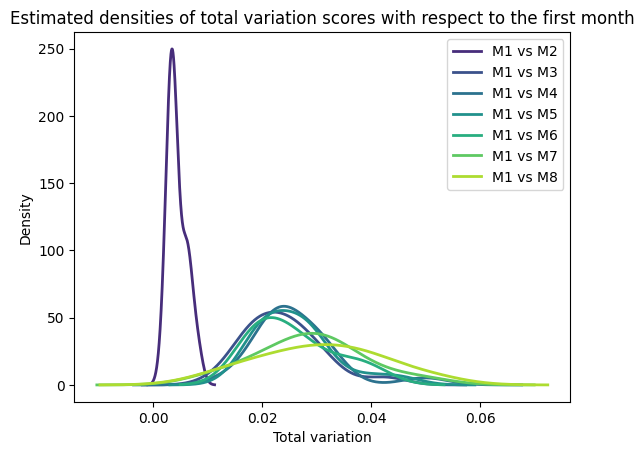

In [14]:
colors = sns.color_palette("viridis", n_colors=len(df.columns))
ax = df.plot.kde(color=colors, linewidth=2)
plt.title('Estimated densities of total variation scores with respect to the first month')
plt.xlabel('Total variation')
plt.ylabel('Density')
labels = ['M1 vs M2', 'M1 vs M3', 'M1 vs M4', 'M1 vs M5', 'M1 vs M6', 'M1 vs M7', 'M1 vs M8']
plt.legend(labels)
plt.show()

# Preference change from previous month

In [15]:
total_variations = []
for i in range(8):
    if i != 0:
        first_slot_active_users = total_active_users[i-1]
        second_slot_active_users = total_active_users[i]
        first_slot_distributions = total_distributions[i-1]
        second_slot_distributions = total_distributions[i]
        common_users_two_slots = list(set(first_slot_active_users) & set(second_slot_active_users))
        filtered_first_slot_distributions = first_slot_distributions[common_users_two_slots]
        filtered_second_slot_distributions = second_slot_distributions[common_users_two_slots]
        variation_distance = torch.abs(filtered_first_slot_distributions - filtered_second_slot_distributions) / 2
        variation_distance = torch.mean(variation_distance, dim=0)
        total_variations.append(variation_distance)

In [16]:
print(len(total_variations))
print(total_variations)

7
[tensor([0.0050, 0.0033, 0.0031, 0.0031, 0.0034, 0.0069, 0.0020, 0.0043, 0.0038,
        0.0037, 0.0036, 0.0061, 0.0063, 0.0037, 0.0026, 0.0060, 0.0082, 0.0030]), tensor([0.0084, 0.0071, 0.0062, 0.0050, 0.0077, 0.0069, 0.0037, 0.0070, 0.0055,
        0.0117, 0.0058, 0.0066, 0.0090, 0.0080, 0.0059, 0.0066, 0.0116, 0.0062]), tensor([0.0038, 0.0051, 0.0041, 0.0045, 0.0059, 0.0053, 0.0033, 0.0058, 0.0028,
        0.0047, 0.0039, 0.0058, 0.0065, 0.0061, 0.0053, 0.0058, 0.0077, 0.0034]), tensor([0.0106, 0.0100, 0.0099, 0.0083, 0.0119, 0.0116, 0.0050, 0.0148, 0.0064,
        0.0114, 0.0095, 0.0099, 0.0134, 0.0133, 0.0120, 0.0143, 0.0145, 0.0078]), tensor([0.0099, 0.0089, 0.0059, 0.0082, 0.0100, 0.0106, 0.0041, 0.0166, 0.0040,
        0.0054, 0.0061, 0.0085, 0.0093, 0.0110, 0.0086, 0.0096, 0.0098, 0.0049]), tensor([0.0164, 0.0101, 0.0075, 0.0080, 0.0186, 0.0140, 0.0059, 0.0212, 0.0050,
        0.0086, 0.0078, 0.0099, 0.0136, 0.0183, 0.0117, 0.0151, 0.0138, 0.0071]), tensor([0.0095, 0.0072, 0

## Plot

In [17]:
for i in range(7):
    series = pd.Series(total_variations[i])
    if i == 0:
        df = pd.DataFrame(series)
    else:
        df = pd.concat([df, series], axis=1)
df

,0,0,0,0,0,0,0
0,0.005045,0.008420,0.003846,0.010631,0.009909,0.016434,0.009458
1,0.003258,0.007065,0.005085,0.010038,0.008881,0.010124,0.007219
2,0.003132,0.006203,0.004104,0.009901,0.005892,0.007546,0.004378
3,0.003124,0.005032,0.004477,0.008341,0.008170,0.007994,0.004288
4,0.003431,0.007730,0.005942,0.011906,0.010050,0.018580,0.014456
5,0.006923,0.006928,0.005322,0.011580,0.010601,0.014005,0.009263
6,0.002032,0.003708,0.003338,0.005016,0.004111,0.005880,0.003755
7,0.004258,0.006953,0.005818,0.014834,0.016633,0.021219,0.012946
8,0.003762,0.005486,0.002815,0.006434,0.003961,0.004970,0.002352
9,0.003745,0.011655,0.004726,0.011405,0.005377,0.008608,0.006958


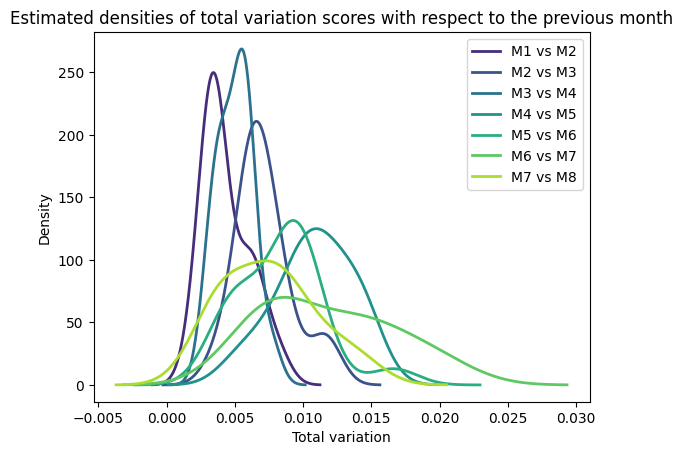

In [18]:
colors = sns.color_palette("viridis", n_colors=len(df.columns))
ax = df.plot.kde(color=colors, linewidth=2)
plt.title('Estimated densities of total variation scores with respect to the previous month')
plt.xlabel('Total variation')
plt.ylabel('Density')
labels = ['M1 vs M2', 'M2 vs M3', 'M3 vs M4', 'M4 vs M5', 'M5 vs M6', 'M6 vs M7', 'M7 vs M8']
plt.legend(labels)
plt.show()

# Preference change from previous month with full history

In [19]:
total_distributions = []
total_active_users = []
for i in range(8):
    months_list_time_slot = []
    months_list_time_slot.append(months_list[0])
    months_list_time_slot.append(months_list[i])
    dataframe_slot = dataframe[dataframe['Month'].isin(months_list_time_slot)]
    dataframe_slot = dataframe_slot.sort_values(by='Timestamp')
    
    slot_distributions = []
    slot_active_users = []
    for user_id in range(dataset.n_users):
        user_dataframe = dataframe_slot[dataframe_slot['UserID'] == user_id]
        user_items = user_dataframe['MovieID'].values
        user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
        slot_distributions.append(user_distribution)
        if active_user:
            slot_active_users.append(user_id)
    slot_distributions = torch.vstack(slot_distributions)
    
    total_distributions.append(slot_distributions)
    total_active_users.append(slot_active_users)

In [20]:
total_variations = []
for i in range(8):
    if i != 0:
        first_slot_active_users = total_active_users[i-1]
        second_slot_active_users = total_active_users[i]
        first_slot_distributions = total_distributions[i-1]
        second_slot_distributions = total_distributions[i]
        common_users_two_slots = list(set(first_slot_active_users) & set(second_slot_active_users))
        filtered_first_slot_distributions = first_slot_distributions[common_users_two_slots]
        filtered_second_slot_distributions = second_slot_distributions[common_users_two_slots]
        variation_distance = torch.abs(filtered_first_slot_distributions - filtered_second_slot_distributions) / 2
        variation_distance = torch.mean(variation_distance, dim=0)
        total_variations.append(variation_distance)

## Plot

In [21]:
for i in range(7):
    series = pd.Series(total_variations[i])
    if i == 0:
        df = pd.DataFrame(series)
    else:
        df = pd.concat([df, series], axis=1)
df

,0,0,0,0,0,0,0
0,0.005045,0.010867,0.012345,0.017370,0.017964,0.017164,0.016763
1,0.003258,0.008133,0.010963,0.013585,0.011275,0.012249,0.010979
2,0.003132,0.007067,0.012738,0.011549,0.008231,0.007245,0.008108
3,0.003124,0.006628,0.011212,0.012761,0.007898,0.005866,0.006584
4,0.003431,0.018790,0.017730,0.020902,0.028060,0.026651,0.022388
5,0.006923,0.012786,0.014976,0.015667,0.014885,0.013312,0.014699
6,0.002032,0.005736,0.007699,0.005039,0.008855,0.007039,0.006218
7,0.004258,0.013957,0.019967,0.030300,0.026074,0.023898,0.028285
8,0.003762,0.008406,0.008907,0.008781,0.006338,0.004812,0.003774
9,0.003745,0.011208,0.011620,0.009034,0.008486,0.011238,0.011408


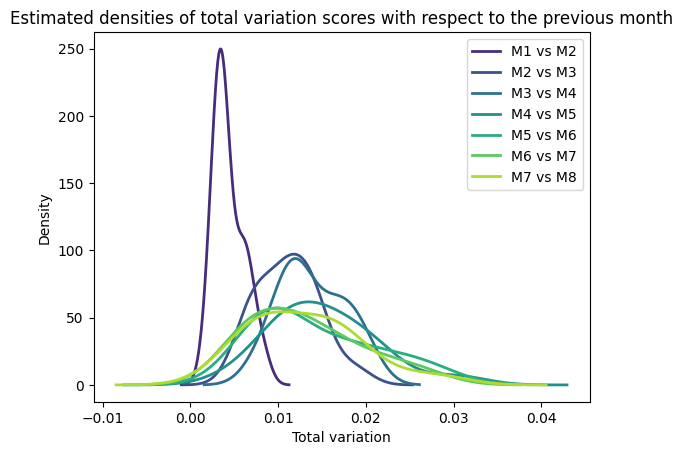

In [22]:
colors = sns.color_palette("viridis", n_colors=len(df.columns))
ax = df.plot.kde(color=colors, linewidth=2)
plt.title('Estimated densities of total variation scores with respect to the previous month')
plt.xlabel('Total variation')
plt.ylabel('Density')
labels = ['M1 vs M2', 'M2 vs M3', 'M3 vs M4', 'M4 vs M5', 'M5 vs M6', 'M6 vs M7', 'M7 vs M8']
plt.legend(labels)
plt.show()